# Plot results from 200 simulations

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd

#### Choose which contrast to plot

In [2]:
# conditions to plot:
contrast = 'vis_aud'  # vis_aud or vis_vis

#### Settings and specs

In [3]:
dir_data_in = '../../output/data/stats'
fig_dir = '../../output/'

snrs = np.arange(-45, 10, 5)

In [4]:
conditions = ['sensor', 'source', 'csp']

file_names = dict(sensor='sensor_scores_%s_%.3f.npy', 
                  source='source_scores_%s_%.3f.npy', 
                  csp='csp_scores_%s_%.3f.npy')
legend = dict(sensor='Sensor space', source='Source space', csp='CSP sensor space', 
              csp_enh='CSP sensor space, enhanced beamf.')
colors = dict(sensor='#01abe9', source='#1b346c', csp='#f54b1a', csp_enh='#657c81')

### Plot accuracies

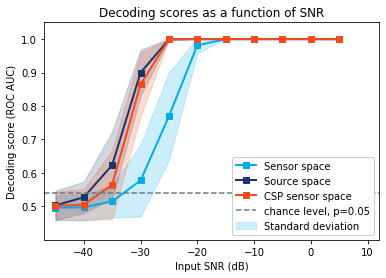

In [5]:
for cond in conditions:
   
    # load the data across the different input SNR realizations:
    mean_score = []
    std_low = []
    std_up = []    
    for snr in snrs:
        file_name = op.join(dir_data_in, file_names[cond])
        score = np.load(file_name % (contrast, snr))

        mean_score.append(np.mean(score))
        std_low.append(np.mean(score) - np.std(score))
        std_up.append(np.mean(score) + np.std(score))
        
    # plot the mean of the scores and the standard deviation
    plt.plot(snrs, mean_score, color=colors[cond], marker='s', linewidth=2, label=legend[cond])
    plt.fill_between(snrs, std_low, std_up, alpha=0.2, color=colors[cond],
                     label=("Standard deviation" if cond == 'sensor' else None))
    
plt.axhline(y=.54, color='#657c81', linestyle='--', label='chance level, p=0.05')
plt.ylabel('Decoding score (ROC AUC)')
plt.xlabel('Input SNR (dB)')
plt.title('Decoding scores as a function of SNR')
plt.xlim(-47, 12)
plt.ylim(0.4, 1.05)
yticks = list(np.arange(0.5, 1.05, 0.1))
plt.yticks(yticks, [str(round(x, 1)) for x in yticks])
fig_fname = op.join(fig_dir, 'decoding_scores_%s.pdf' % contrast)
plt.legend(loc='lower right', framealpha=1.0)
plt.savefig(fig_fname)
plt.show()

### Plot localization error

In [6]:
file_names = dict(csp='csp_coords_%s_%.3f.npy',
                  source='source_coords_%s_%.3f.npy',
                  sim='sim_coords_%s_%.3f.npy',
                  csp_enh='csp_coords_%s_multipliers_%.3f.npy',
                  sensor='sensor_coords_%s_%.3f.npy'
                 )

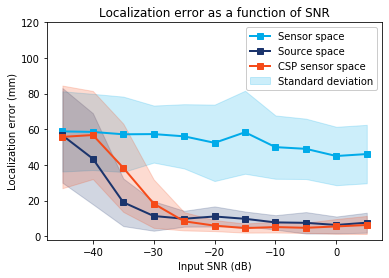

,-45,-40,-35,-30,-25,-20,-15,-10,-5,0,5
sensor,58.83,58.52,57.20,57.32,56.06,52.41,58.34,50.00,49.03,45.01,46.11
sensor std,22.50,21.37,21.14,16.01,18.03,21.44,23.28,17.76,16.94,16.39,16.40
source,56.59,43.49,19.04,11.35,9.83,11.09,9.78,7.76,7.52,6.33,7.60
source std,26.54,25.54,13.35,8.26,4.45,5.64,4.09,4.05,6.02,4.73,5.59
csp,55.74,56.79,38.40,18.27,8.38,5.95,4.56,5.14,4.74,5.50,6.32
csp std,28.79,24.71,24.75,13.56,5.12,3.08,2.54,3.05,2.87,4.14,5.07


In [7]:
conditions = ['sensor', 'source', 'csp']  
data_frame = pd.DataFrame()
for cond in conditions:
    
    mean_error = []
    std_error = []
    std_low = []
    std_up = []
    for snr in snrs:
        coords = np.load(op.join(dir_data_in, file_names[cond] % (contrast, snr)))
        sim_coords = np.load(op.join(dir_data_in, file_names['sim'] % (contrast, snr)))
        
        # loop over 200 realizations
        error_min = []
        for c_est, c_sim in zip(coords, sim_coords):
            error_left = np.linalg.norm(c_sim[0] - c_est)
            error_right = np.linalg.norm(c_sim[1] - c_est)
            error_min.append(np.min((error_left, error_right)))
            
        # get mean and std
        mean_error.append(np.mean(error_min))
        std_error.append(np.std(error_min))
        std_low.append(np.mean(error_min) - np.std(error_min))
        std_up.append(np.mean(error_min) + np.std(error_min))       
 
    plt.plot(snrs, mean_error, color=colors[cond], marker='s', linewidth=2, label=legend[cond])
    plt.fill_between(snrs, std_low, std_up, color=colors[cond], alpha=0.2, 
                     label=("Standard deviation" if cond == 'sensor' else None))
      
    data_frame[cond] = np.round(mean_error, 2)
    data_frame[cond + ' std'] = np.round(std_error, 2)

#plt.xlim(-0.01, 0.6)
plt.ylim(-2, 120)
plt.xlabel('Input SNR (dB)')
plt.ylabel('Localization error (mm)')
plt.title('Localization error as a function of SNR')
plt.legend(loc='upper right', framealpha=1.0)
fig_fname = op.join(fig_dir, 'local_errors_%s.pdf' % contrast)
plt.savefig(fig_fname)
plt.show()

# prettify and plot data frame for value access
data_frame.index = np.round(snrs, 3)
data_frame.T

In [8]:
# export the data frame to LaTeX
data_frame.T.to_latex()


'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &    -45 &    -40 &    -35 &    -30 &    -25 &    -20 &    -15 &    -10 &    -5  &     0  &     5  \\\\\n\\midrule\nsensor     &  58.83 &  58.52 &  57.20 &  57.32 &  56.06 &  52.41 &  58.34 &  50.00 &  49.03 &  45.01 &  46.11 \\\\\nsensor std &  22.50 &  21.37 &  21.14 &  16.01 &  18.03 &  21.44 &  23.28 &  17.76 &  16.94 &  16.39 &  16.40 \\\\\nsource     &  56.59 &  43.49 &  19.04 &  11.35 &   9.83 &  11.09 &   9.78 &   7.76 &   7.52 &   6.33 &   7.60 \\\\\nsource std &  26.54 &  25.54 &  13.35 &   8.26 &   4.45 &   5.64 &   4.09 &   4.05 &   6.02 &   4.73 &   5.59 \\\\\ncsp        &  55.74 &  56.79 &  38.40 &  18.27 &   8.38 &   5.95 &   4.56 &   5.14 &   4.74 &   5.50 &   6.32 \\\\\ncsp std    &  28.79 &  24.71 &  24.75 &  13.56 &   5.12 &   3.08 &   2.54 &   3.05 &   2.87 &   4.14 &   5.07 \\\\\n\\bottomrule\n\\end{tabular}\n'

### Plot activation spread

In [9]:
file_names = dict(csp='csp_spread_%s_%.3f.npy',
                  source='source_spread_%s_%.3f.npy',
                  csp_enh='csp_spread_%s_multipliers_%.3f.npy',
                  sensor='sensor_spread_%s_%.3f.npy')

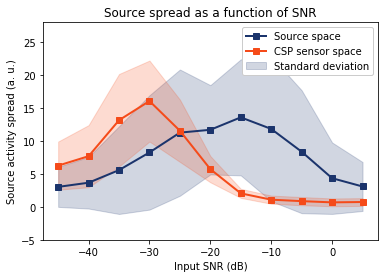

In [10]:
conditions = ['source', 'csp']  # no sensor space activation spread
for cond in conditions:
    
    mean_spread = []
    std_low = []
    std_up = []    
    for snr in snrs:
        file_name = op.join(dir_data_in, file_names[cond])
        spread = np.load(file_name % (contrast, snr))

        mean_spread.append(np.mean(spread))
        std_low.append(np.mean(spread) - np.std(spread))
        std_up.append(np.mean(spread) + np.std(spread))

    plt.plot(snrs, mean_spread, color=colors[cond], marker='s', linewidth=2, label=legend[cond])
    plt.fill_between(snrs, std_low, std_up, color=colors[cond], alpha=0.2, 
                     label=("Standard deviation" if cond == 'source' else None))
    

fig_fname = op.join(fig_dir, 'source_spread_%s.pdf' % contrast)
# plt.xlim(-0.01, 0.6)
plt.ylim(-5, 28)
plt.xlabel('Input SNR (dB)')
plt.ylabel('Source activity spread (a. u.)')
plt.title('Source spread as a function of SNR')
plt.legend(loc='upper right', framealpha=1.0)
plt.savefig(fig_fname)
plt.show()

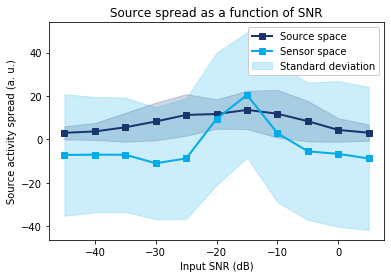

In [11]:
conditions = conditions = ['source', 'sensor']  
for cond in conditions:
    
    mean_spread = []
    std_low = []
    std_up = []    
    for snr in snrs:
        file_name = op.join(dir_data_in, file_names[cond])
        spread = np.load(file_name % (contrast, snr))

        mean_spread.append(np.mean(spread))
        std_low.append(np.mean(spread) - np.std(spread))
        std_up.append(np.mean(spread) + np.std(spread))

    plt.plot(snrs, mean_spread, color=colors[cond], marker='s', linewidth=2, label=legend[cond])
    plt.fill_between(snrs, std_low, std_up, color=colors[cond], alpha=0.2, 
                     label=("Standard deviation" if cond == 'sensor' else None))
    

fig_fname = op.join(fig_dir, 'source_spread_w_sensor_%s.pdf' % contrast)
# plt.xlim(-0.01, 0.6)
# plt.ylim(0.9, 2.0)
plt.xlabel('Input SNR (dB)')
plt.ylabel('Source activity spread (a. u.)')
plt.title('Source spread as a function of SNR')
plt.legend(loc='upper right', framealpha=1.0)
plt.savefig(fig_fname)
plt.show()

### Plot computational time

In [12]:
conditions = ['sensor', 'source', 'csp']
file_names = dict(sensor='sensor_time_%s_%.3f.npy', 
                  csp='csp_time_%s_%.3f.npy',
                  source='source_time_%s_%.3f.npy')

In [13]:
from warnings import warn

if contrast == 'vis_vis':
    warn('No computational time estimates for contrast "vis_vis", plotting "vis_aud" instead.')
    contrast = 'vis_aud'

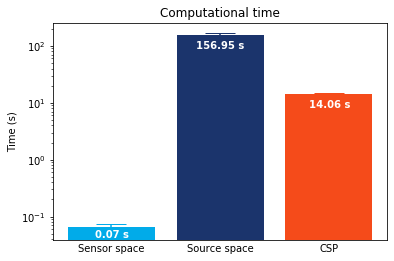

In [14]:
positions = range(3)
text_positions = [0.0425, 90, 8.2]
x_positions = [0.15, 0.225, 0.18]  # get the text positions right relative to lenght of text
fig, ax = plt.subplots()

for cond, pos, text_pos, x_pos in zip(conditions, positions, text_positions, x_positions):
    
    # gather data from all SNR realizations 
    time_data = []
    for snr in snrs:
        file_name = op.join(dir_data_in, file_names[cond])
        times = np.load(file_name % (contrast, snr))
        time_data.extend(times)
    
    mean_time = np.mean(time_data)
    ax.bar(pos, height=mean_time, color=colors[cond], yerr=np.std(time_data),
           ecolor=colors[cond], capsize=15, linewidth=2)
    # add the average time:
    ax.text(pos-x_pos, text_pos, '%s s' % str(round(mean_time, 2)), color='white', weight='bold')

# x axis
ax.set_xticks(positions)
ax.set_xticklabels(['Sensor space', 'Source space', 'CSP'])
ax.tick_params(axis='x', length=0)  # prevent x ticks from showing

# other specs:
plt.ylabel('Time (s)')
plt.title('Computational time')
plt.yscale('log')

# save file
fig_fname = op.join(fig_dir, 'computation_time_%s.pdf' % contrast)
plt.savefig(fig_fname)
plt.show()